In [2]:
#!pip install capytaine #uncomment if first time running
omega = 1.05
w = 1
rho = 1023 # density of our special material
wave_amp = 1

import capytaine as cpt
import numpy as np
import matplotlib.pyplot as plt
from capytaine.bem.airy_waves import airy_waves_potential, airy_waves_velocity, froude_krylov_force

import time

# In[3]:
#make a compound cylinder
h = 1.05
a1 = 0.5
a2 = 1
d1 = 0.5
d2 = 0.25
resolution = 0.4

solver = cpt.BEMSolver()
def bemCompoundCylinder(h,a1,a2,d1,d2,resolution):
  body2 = cpt.meshes.predefined.mesh_vertical_cylinder(radius= a2,center=(0,0,0),length = d2,faces_max_radius=resolution*a2)
  body1 = cpt.meshes.predefined.mesh_vertical_cylinder(radius=a1,center=(0,0,0),length = d1-d2,faces_max_radius=resolution*a2)
  body1 = body1.translated([0,0,-d2-0.001])

  body = body1 + body2
  body = cpt.FloatingBody(body)
  body.add_translation_dof(name='Heave')
  body = body.immersed_part()
  #body.show_matplotlib()
  faces_centers = body.mesh.faces_centers

  rad_problem = cpt.RadiationProblem(body=body,
                                        wavenumber = w, water_depth=h)
  results = solver.solve(rad_problem, keep_details = True)
  dataset = cpt.assemble_dataset([results])
  A = np.array(dataset['added_mass']) # added mass
  B = np.array(dataset['radiation_damping'])
  return A,B, body.mesh.nb_faces

result = bemCompoundCylinder(h,a1,a2,d1,d2,resolution) #compile it first
def timeit(res,iter):
  def oneRun(res):
    start_time = time.time()
    result = bemCompoundCylinder(h,a1,a2,d1,d2,res)
    end_time = time.time()
    return end_time-start_time
  avg_time = np.mean([oneRun(res) for i in range(iter)])
  return avg_time

avg_time = timeit(resolution,100)#default resolution

print(f"Execution time: {avg_time} seconds") #run more than once ..second time is the actual runtime that excludes compile time


Execution time: 0.08868858575820923 seconds


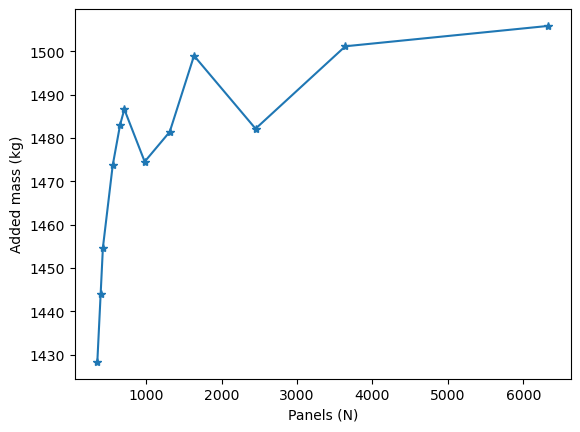

In [14]:

resolutions = np.arange(0.03,0.15,0.01)
results = [bemCompoundCylinder(h,a1,a2,d1,d2,res) for res in resolutions]
npanels = [res[2] for res in results]
A = [res[0].flatten() for res in results]

plt.figure()
plt.plot(npanels,A,'*-')
plt.xlabel("Panels (N)")
plt.ylabel("Added mass (kg)")
plt.show()

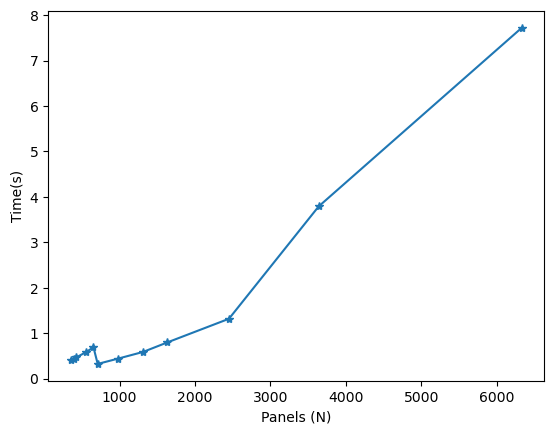

In [15]:
times = [timeit(res,10) for res in resolutions]


plt.figure()
plt.plot(npanels,times,'*-')
plt.xlabel("Panels (N)")
plt.ylabel("Time(s)")
plt.show()
